In [10]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
# 过滤特定类型的警告
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")
warnings.filterwarnings("ignore", category=ConvergenceWarning, module="statsmodels")

# 设置中文显示
plt.rcParams['font.family'] = ['Microsoft YaHei'] 
plt.rcParams['axes.unicode_minus'] = False

In [11]:
# 读取数据
df = pd.read_excel(r'每日行情\601668.SH.xlsx', skiprows=2, nrows=1690)

In [12]:
# 数据清洗
def clean_stock_data(df):
    # 检查所有数据是否有缺失值
    missing_values = df.isnull().sum()
    print("各列缺失值数量：")
    print(missing_values)
    
    # 检查收盘价是否在最高价和最低价之间
    invalid_prices = ~((df['收盘价(元)'] >= df['最低价(元)']) & 
                      (df['收盘价(元)'] <= df['最高价(元)']))
    
    # 对无效价格进行修正(使用前一天或后一天的收盘价)
    if invalid_prices.any():
        df.loc[invalid_prices, '收盘价(元)'] = df['收盘价(元)'].shift(1)
        df.loc[invalid_prices, '收盘价(元)'].fillna(df['收盘价(元)'].shift(-1))
    
    return df

# 清洗数据
df_cleaned = clean_stock_data(df)

各列缺失值数量：
交易日期      0
开盘价(元)    0
最高价(元)    0
最低价(元)    0
收盘价(元)    0
成交量(股)    0
成交额(元)    0
dtype: int64


In [13]:
def check_stationarity(data):
    """进行ADF检验"""
    adf_result = adfuller(data)
    print('\n平稳性检验结果:')
    print(f'ADF统计量: {adf_result[0]:.4f}')
    print(f'p值: {adf_result[1]:.4f}')
    for key, value in adf_result[4].items():
        print(f'临界值 ({key}): {value:.4f}')
    
    is_stationary = adf_result[1] < 0.05
    print(f'序列是否平稳: {"是" if is_stationary else "否"}')
    return is_stationary

def check_stationarity_dftest(data):
    """进行DF-GLS平稳性检验"""
    dftest_result = adfuller(data, regression='ct')
    print('\nDF-GLS平稳性检验结果:')
    print(f'DF-GLS统计量: {dftest_result[0]:.4f}')
    print(f'p值: {dftest_result[1]:.4f}')
    for key, value in dftest_result[4].items():
        print(f'临界值 ({key}): {value:.4f}')
    
    is_stationary_dftest = dftest_result[1] < 0.05
    print(f'序列是否平稳 (DF-GLS): {"是" if is_stationary_dftest else "否"}')
    return is_stationary_dftest

def check_stationarity_kpss(data):
    """进行KPSS检验"""
    kpss_result = kpss(data, regression='c')
    print('\nKPSS平稳性检验结果:')
    print(f'KPSS统计量: {kpss_result[0]:.4f}')
    print(f'p值: {kpss_result[1]:.4f}')
    for key, value in kpss_result[3].items():
        print(f'临界值 ({key}): {value:.4f}')
    
    is_stationary_kpss = kpss_result[1] > 0.05
    print(f'序列是否平稳 (KPSS): {"是" if is_stationary_kpss else "否"}')
    return is_stationary_kpss

def check_white_noise(data):
    """进行白噪声检验"""
    lb_result = acorr_ljungbox(data, lags=[10], return_df=True)
    print('\n白噪声检验结果:')
    print(f'Ljung-Box统计量: {lb_result["lb_stat"].values[0]:.4f}')
    print(f'p值: {lb_result["lb_pvalue"].values[0]:.4f}')
    
    is_white_noise = lb_result["lb_pvalue"].values[0] < 0.05
    print(f'序列是否非白噪声: {"非白噪声" if is_white_noise else "白噪声"}')
    return is_white_noise

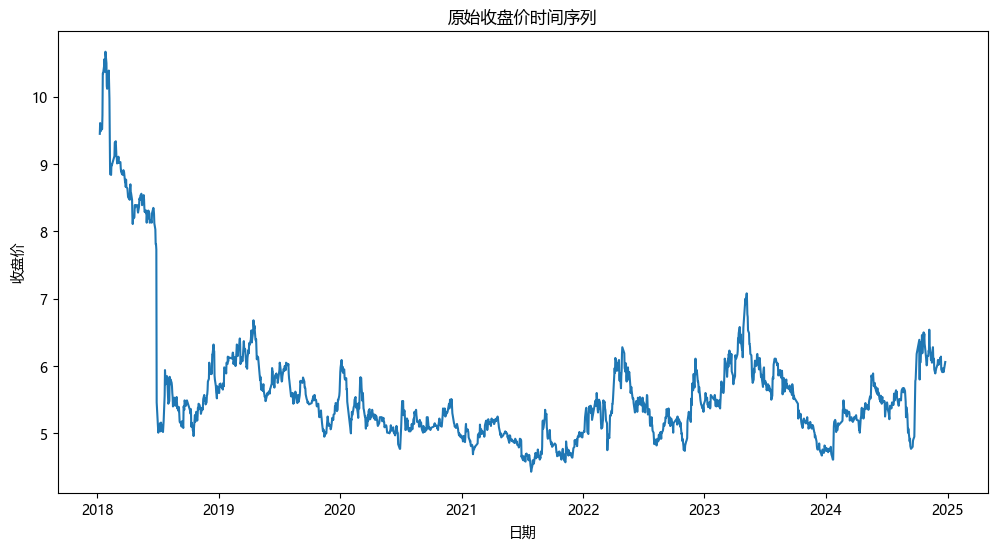

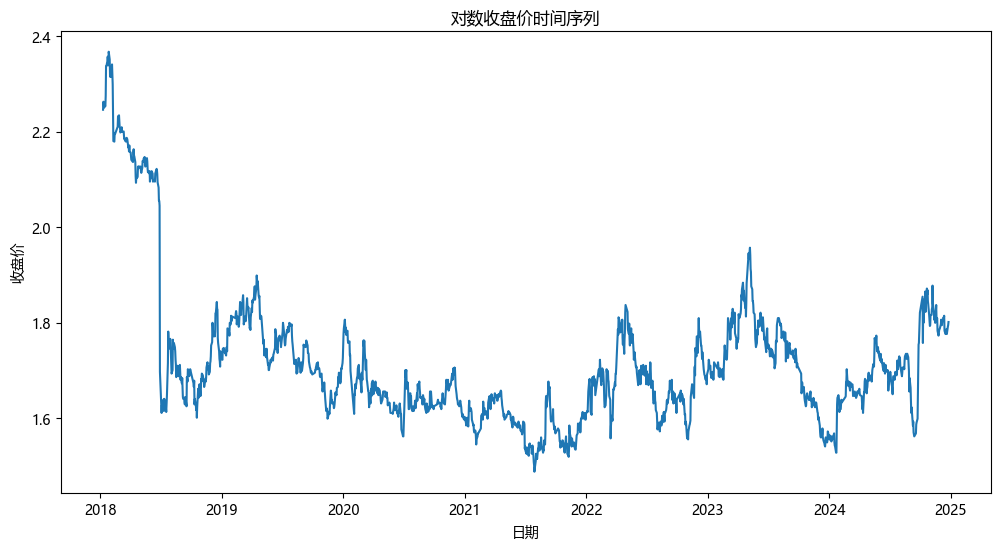

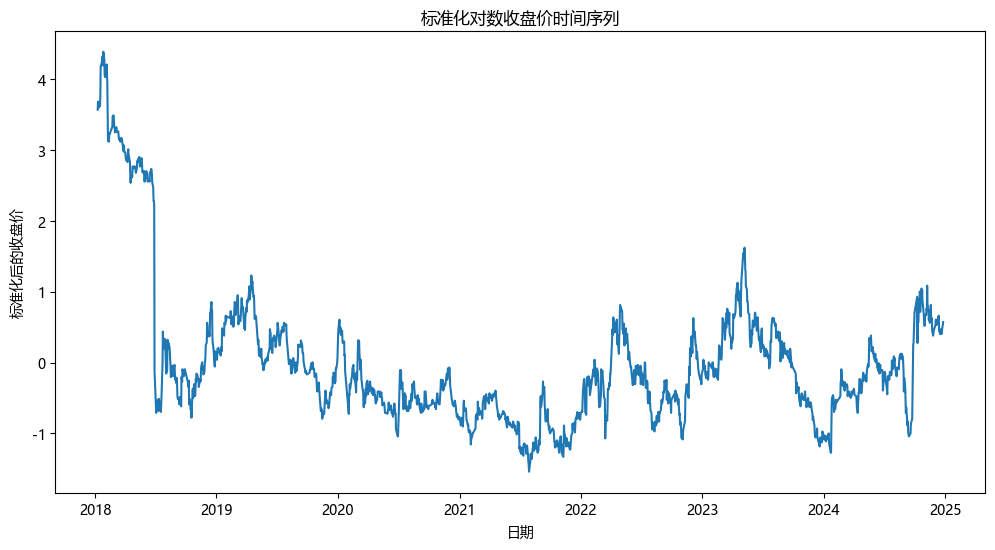


标准化序列检验结果:

平稳性检验结果:
ADF统计量: -4.4286
p值: 0.0003
临界值 (1%): -3.4342
临界值 (5%): -2.8633
临界值 (10%): -2.5677
序列是否平稳: 是

DF-GLS平稳性检验结果:
DF-GLS统计量: -4.1239
p值: 0.0058
临界值 (1%): -3.9642
临界值 (5%): -3.4131
临界值 (10%): -3.1286
序列是否平稳 (DF-GLS): 是

KPSS平稳性检验结果:
KPSS统计量: 1.3700
p值: 0.0100
临界值 (10%): 0.3470
临界值 (5%): 0.4630
临界值 (2.5%): 0.5740
临界值 (1%): 0.7390
序列是否平稳 (KPSS): 否

白噪声检验结果:
Ljung-Box统计量: 14699.2091
p值: 0.0000
序列是否非白噪声: 非白噪声


C:\Users\93516\AppData\Local\Temp\ipykernel_29848\3643794736.py:29: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(data, regression='c')


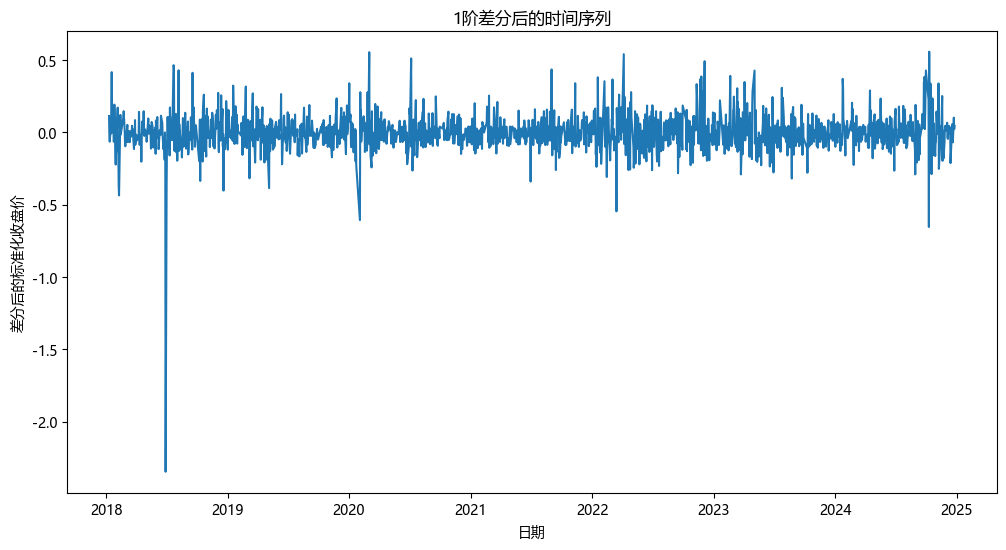


1阶差分后数据检验结果:

平稳性检验结果:
ADF统计量: -15.0544
p值: 0.0000
临界值 (1%): -3.4342
临界值 (5%): -2.8633
临界值 (10%): -2.5677
序列是否平稳: 是

DF-GLS平稳性检验结果:
DF-GLS统计量: -12.1646
p值: 0.0000
临界值 (1%): -3.9642
临界值 (5%): -3.4131
临界值 (10%): -3.1286
序列是否平稳 (DF-GLS): 是

KPSS平稳性检验结果:
KPSS统计量: 0.1953
p值: 0.1000
临界值 (10%): 0.3470
临界值 (5%): 0.4630
临界值 (2.5%): 0.5740
临界值 (1%): 0.7390
序列是否平稳 (KPSS): 是

白噪声检验结果:
Ljung-Box统计量: 21.6525
p值: 0.0170
序列是否非白噪声: 非白噪声

数据准备完成:
差分阶数: 1
训练集大小: 1521
测试集大小: 169


C:\Users\93516\AppData\Local\Temp\ipykernel_29848\3643794736.py:29: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(data, regression='c')


In [14]:
# 1. 基础数据处理
df.index = pd.to_datetime(df['交易日期'])
prices = np.array(df['收盘价(元)'])
dates = np.array(df.index)
plt.figure(figsize=(12, 6))
plt.plot(dates, prices)
plt.title('原始收盘价时间序列')
plt.xlabel('日期')
plt.ylabel('收盘价')
plt.show()

# 2. 对数变换和标准化处理
prices_log = np.log(prices)
plt.figure(figsize=(12, 6))
plt.plot(dates, prices_log)
plt.title('对数收盘价时间序列')
plt.xlabel('日期')
plt.ylabel('收盘价')
plt.show()
scaler = StandardScaler()
prices_log_scaled = scaler.fit_transform(prices_log.reshape(-1, 1)).ravel()

# 3. 可视化标准化序列
plt.figure(figsize=(12, 6))
plt.plot(dates, prices_log_scaled)
plt.title('标准化对数收盘价时间序列')
plt.xlabel('日期')
plt.ylabel('标准化后的收盘价')
plt.show()

# 4. 检验标准化序列
print("\n标准化序列检验结果:")
is_stationary = check_stationarity(prices_log_scaled)
is_stationary_dftest = check_stationarity_dftest(prices_log_scaled)
is_stationary_kpss = check_stationarity_kpss(prices_log_scaled)
is_not_white_noise = check_white_noise(prices_log_scaled)

# 5. 如果不平稳，进行差分处理
d = 0
curr_data = prices_log_scaled.copy()
curr_dates = dates

while not is_stationary or not is_stationary_dftest or not is_stationary_kpss or not is_not_white_noise and d < 2:
    d += 1
    curr_data = np.diff(curr_data)
    curr_dates = dates[d:]
    
    # 可视化差分后的序列
    plt.figure(figsize=(12, 6))
    plt.plot(curr_dates, curr_data)
    plt.title(f'{d}阶差分后的时间序列')
    plt.xlabel('日期')
    plt.ylabel('差分后的标准化收盘价')
    plt.show()
    
    print(f"\n{d}阶差分后数据检验结果:")
    is_stationary = check_stationarity(curr_data)
    is_stationary_dftest = check_stationarity_dftest(curr_data)
    is_stationary_kpss = check_stationarity_kpss(curr_data)
    is_not_white_noise = check_white_noise(curr_data)

# 6. 检查建模条件
if not is_stationary or not is_stationary_dftest or not is_stationary_kpss:
    raise ValueError("二阶差分后仍不平稳")
if not is_not_white_noise:
    raise ValueError("序列为白噪声")

# 7. 划分训练集和测试集
train_size = int(len(prices_log_scaled) * 0.9)
train_data = prices_log_scaled[:train_size]
test_data = prices_log_scaled[train_size:]

print(f"\n数据准备完成:")
print(f"差分阶数: {d}")
print(f"训练集大小: {len(train_data)}")
print(f"测试集大小: {len(test_data)}")

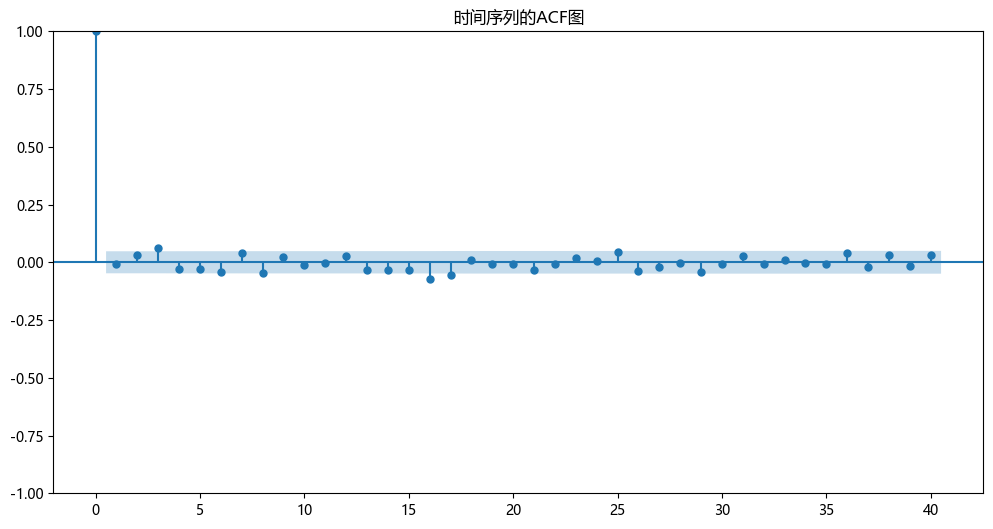

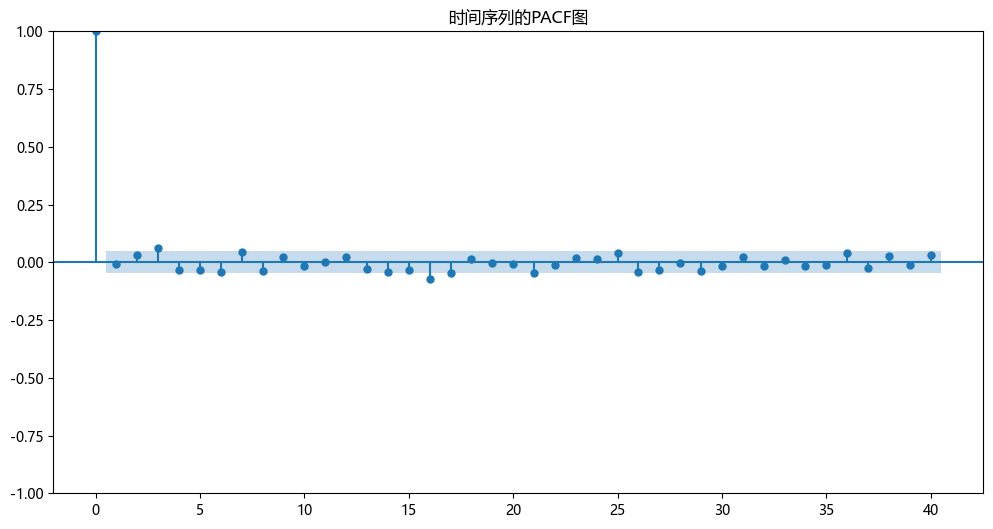

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 画出ACF图
plt.figure(figsize=(12, 6))
plot_acf(curr_data, lags=40, ax=plt.gca())
plt.title('时间序列的ACF图')
plt.show()

# 画出PACF图
plt.figure(figsize=(12, 6))
plot_pacf(curr_data, lags=40, ax=plt.gca())
plt.title('时间序列的PACF图')
plt.show()

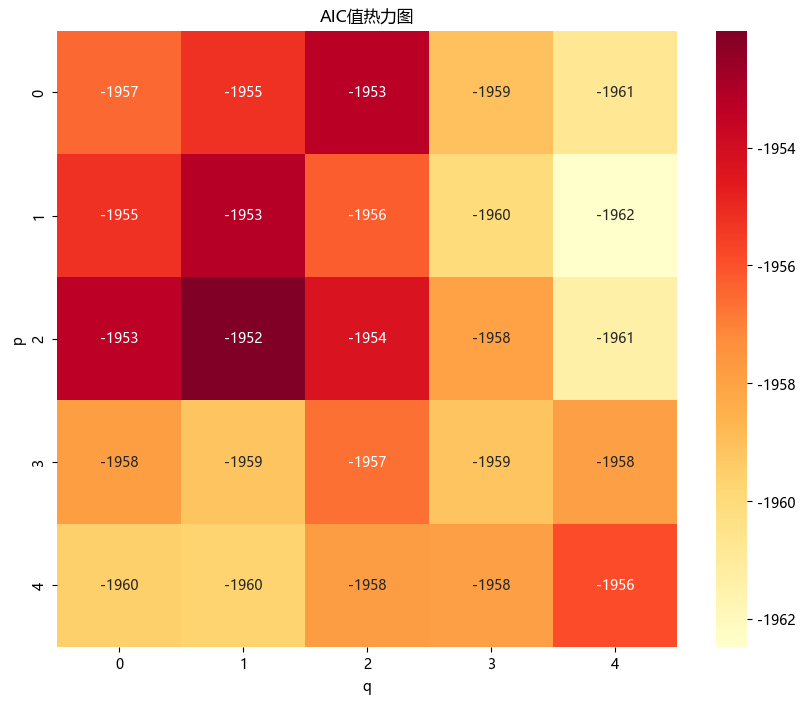

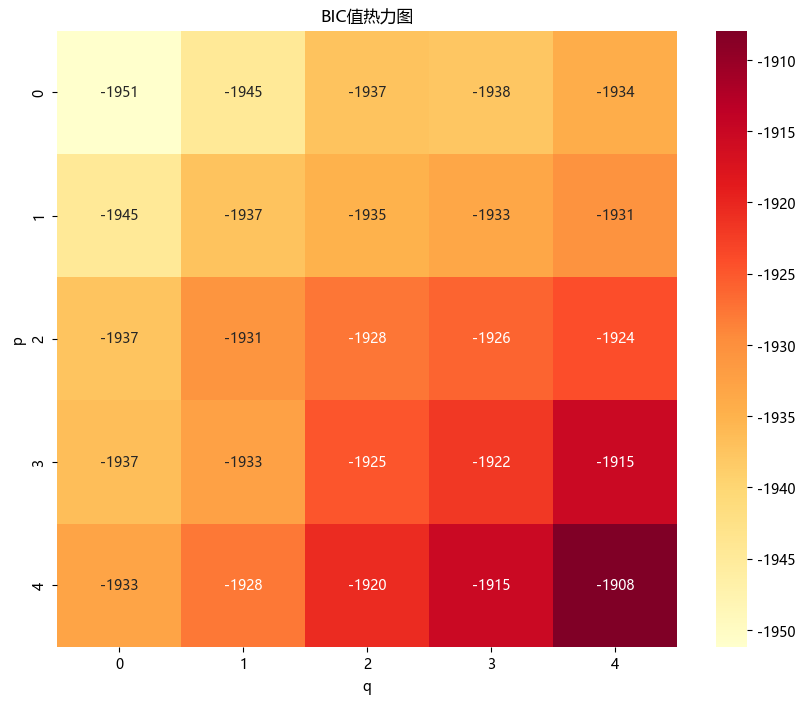


AIC最优参数:
p=1, d=1, q=4
AIC=-1962.48

BIC最优参数:
p=0, d=1, q=0
BIC=-1951.17


In [16]:
import seaborn as sns

def grid_search_parameters(train_data, d):
    """网格搜索ARIMA最佳参数"""
    p_range = range(0, 5)
    q_range = range(0, 5)
    
    # 使用列表存储结果
    results_list = []
    
    for p in p_range:
        for q in q_range:
            try:
                model = ARIMA(train_data, order=(p, d, q))
                results_fit = model.fit()
                results_list.append({
                    'p': p,
                    'd': d,
                    'q': q,
                    'aic': results_fit.aic,
                    'bic': results_fit.bic
                })
            except:
                continue
    
    # 创建DataFrame并排序
    results = pd.DataFrame(results_list)
    results = results.sort_values(['aic', 'bic'])
    
    return results

# 执行网格搜索
results = grid_search_parameters(train_data, d)

# 生成热力图
plt.figure(figsize=(10, 8))
aic_pivot = results.pivot(index='p', columns='q', values='aic')
sns.heatmap(aic_pivot, annot=True, fmt='.0f', cmap='YlOrRd')
plt.title('AIC值热力图')
plt.xlabel('q')
plt.ylabel('p')
plt.show()

plt.figure(figsize=(10, 8))
bic_pivot = results.pivot(index='p', columns='q', values='bic')
sns.heatmap(bic_pivot, annot=True, fmt='.0f', cmap='YlOrRd')
plt.title('BIC值热力图')
plt.xlabel('q')
plt.ylabel('p')
plt.show()

# 获取唯一最优参数
best_aic = results.sort_values('aic').iloc[0]
best_bic = results.sort_values('bic').iloc[0]

print("\nAIC最优参数:")
print(f"p={int(best_aic['p'])}, d={d}, q={int(best_aic['q'])}")
print(f"AIC={best_aic['aic']:.2f}")

print("\nBIC最优参数:")
print(f"p={int(best_bic['p'])}, d={d}, q={int(best_bic['q'])}")
print(f"BIC={best_bic['bic']:.2f}")

In [19]:
# 根据ACF、PACF、热力图确定最佳参数为（0，1，0）
best_order = (1, 1, 4)

# 训练最终模型
model = ARIMA(train_data, order=best_order)
results = model.fit()

# 打印模型诊断信息
print(results.summary())

# 获取残差
residuals = results.resid

# 对残差进行白噪声检验
is_residuals_white_noise = check_white_noise(residuals)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1521
Model:                 ARIMA(1, 1, 4)   Log Likelihood                 987.238
Date:                Sun, 29 Dec 2024   AIC                          -1962.476
Time:                        17:10:52   BIC                          -1930.517
Sample:                             0   HQIC                         -1950.578
                               - 1521                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8901      0.068     13.101      0.000       0.757       1.023
ma.L1         -0.8672      0.071    -12.143      0.000      -1.007      -0.727
ma.L2         -0.0128      0.033     -0.382      0.7

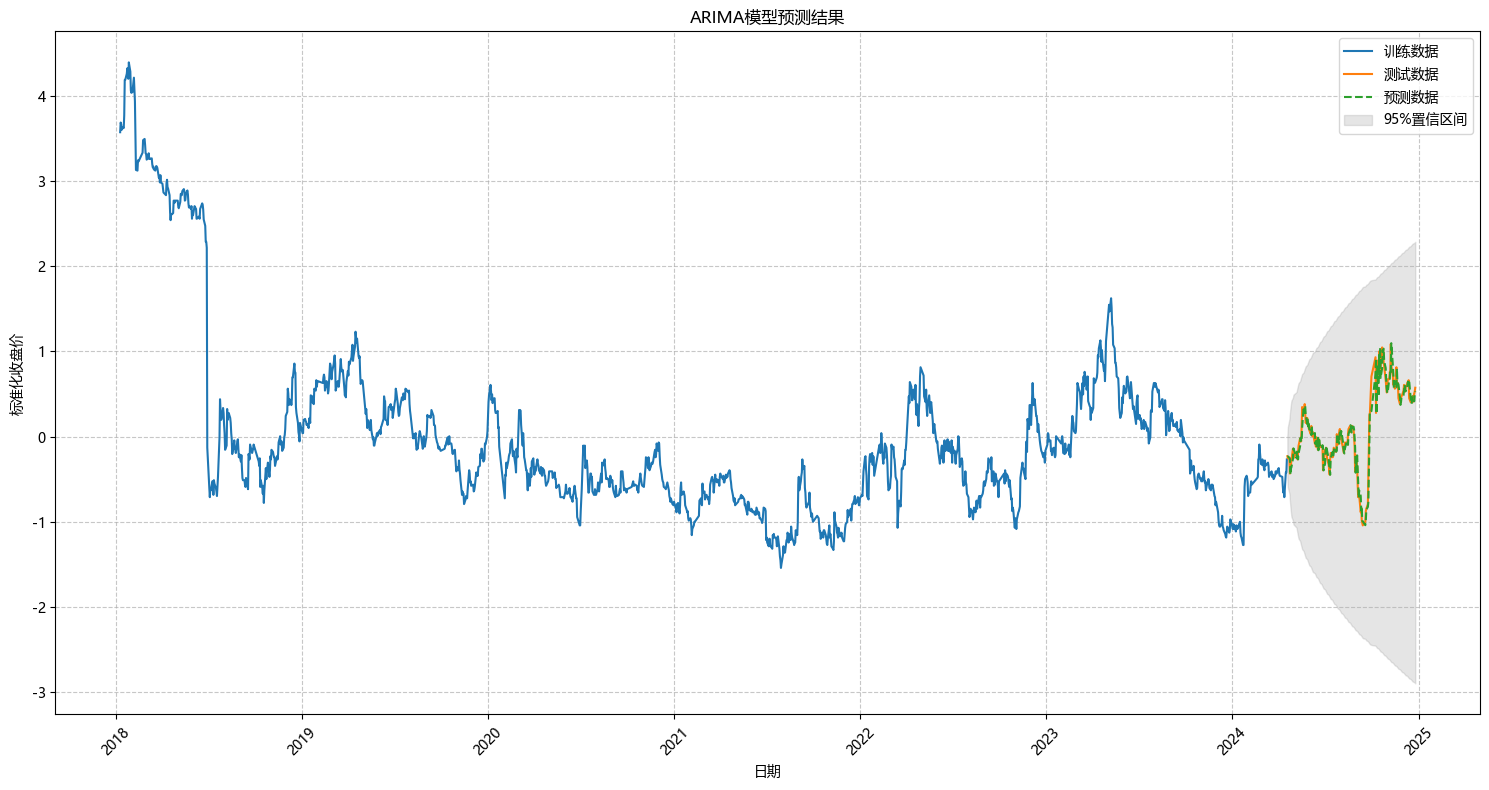

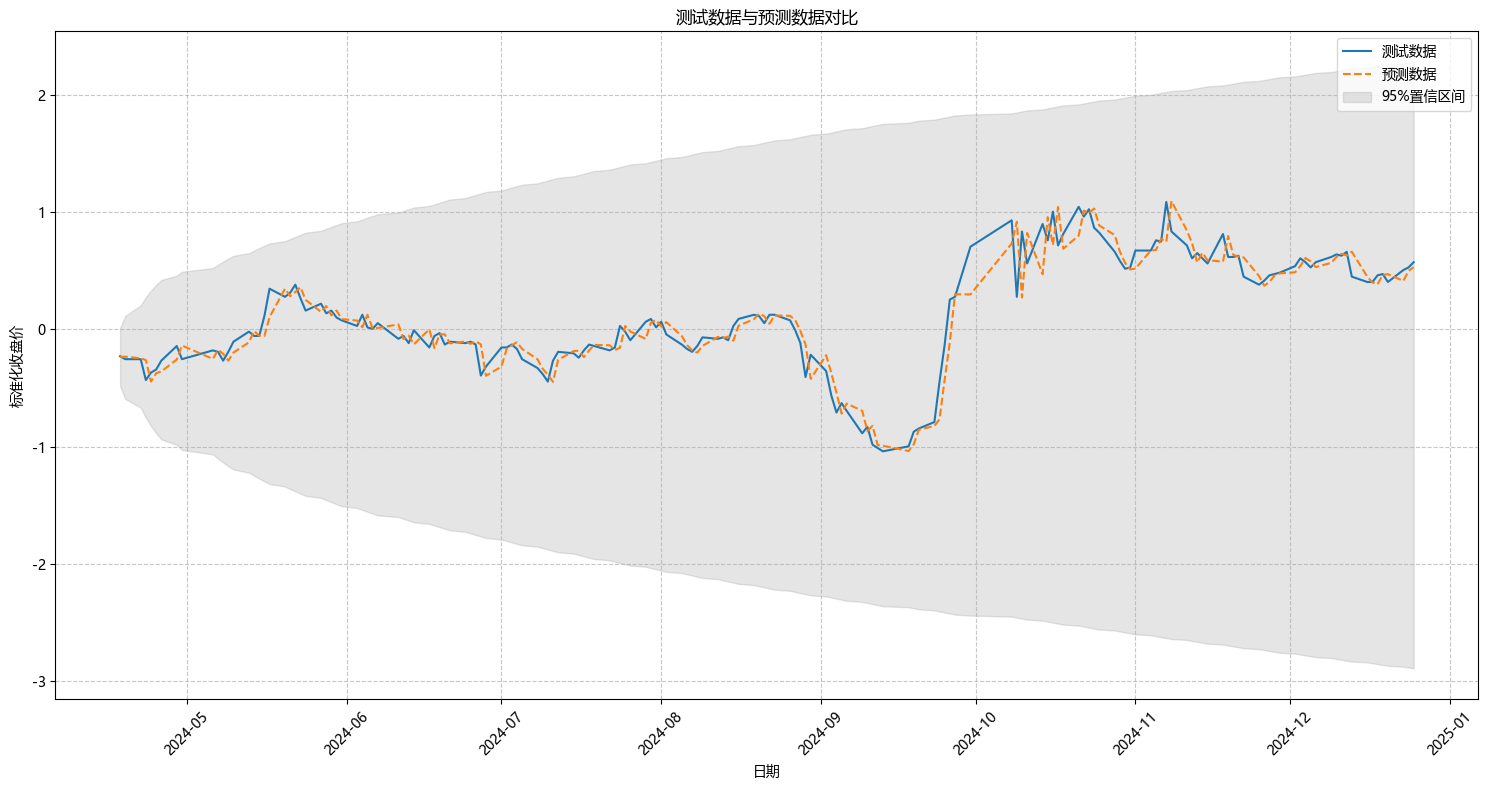

最佳ARIMA参数: (1, 1, 4)
测试集RAE: 0.2497
测试集RSE: 0.0890


In [20]:
# 逐步预测测试集
forecast = []
history = list(train_data)
for t in range(len(test_data)):
    model = ARIMA(history, order=best_order)
    model_fit = model.fit()
    yhat = model_fit.forecast(steps=1)[0]
    forecast.append(yhat)
    history.append(test_data[t])
forecast = np.array(forecast)

# 计算评估指标
rae = np.sum(np.abs(test_data - forecast)) / np.sum(np.abs(test_data - np.mean(test_data)))
rse = np.sum((test_data - forecast)**2) / np.sum((test_data - np.mean(test_data))**2)

# 获取预测置信区间
forecast_ci = results.get_forecast(steps=len(test_data)).conf_int()

# 获取训练集和测试集对应的日期
train_dates = dates[:len(train_data)]
test_dates = dates[len(train_data):len(train_data) + len(test_data)]

# 绘制完整预测结果图
plt.figure(figsize=(15, 8))
plt.plot(train_dates, train_data, label='训练数据')
plt.plot(test_dates, test_data, label='测试数据')
plt.plot(test_dates, forecast, label='预测数据', linestyle='--')
plt.fill_between(test_dates, 
                 forecast_ci[:, 0], forecast_ci[:, 1], 
                 color='gray', alpha=0.2, label='95%置信区间')

plt.title('ARIMA模型预测结果')
plt.xlabel('日期')
plt.ylabel('标准化收盘价')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# 绘制测试集部分放大图
plt.figure(figsize=(15, 8))
plt.plot(test_dates, test_data, label='测试数据')
plt.plot(test_dates, forecast, label='预测数据', linestyle='--')
plt.fill_between(test_dates, 
                 forecast_ci[:, 0], forecast_ci[:, 1], 
                 color='gray', alpha=0.2, label='95%置信区间')

plt.title('测试数据与预测数据对比')
plt.xlabel('日期')
plt.ylabel('标准化收盘价')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# 打印结果
print(f'最佳ARIMA参数: {best_order}')
print(f'测试集RAE: {rae:.4f}')
print(f'测试集RSE: {rse:.4f}')